Analyzing 31 time periods

LAG ANALYSIS - Do emotions PREDICT future returns?

EMOTIONS PREDICTING RETURNS 1 PERIOD(S) AHEAD

Top 10 predictive emotions (positive):
approval         0.433917
realization      0.359376
embarrassment    0.264282
disgust          0.258324
surprise         0.256208
optimism         0.251631
amusement        0.247489
desire           0.214730
fear             0.205098
excitement       0.204677
dtype: float64

Top 10 predictive emotions (negative):
nervousness    0.127619
joy            0.124238
relief         0.109213
anger          0.023634
disapproval   -0.081388
remorse       -0.257012
sadness       -0.326364
gratitude     -0.334876
grief         -0.336385
caring        -0.432196
dtype: float64

EMOTIONS PREDICTING RETURNS 2 PERIOD(S) AHEAD

Top 10 predictive emotions (positive):
nervousness       0.475060
disappointment    0.473747
embarrassment     0.362816
relief            0.332846
admiration        0.309242
gratitude         0.308626
surprise        

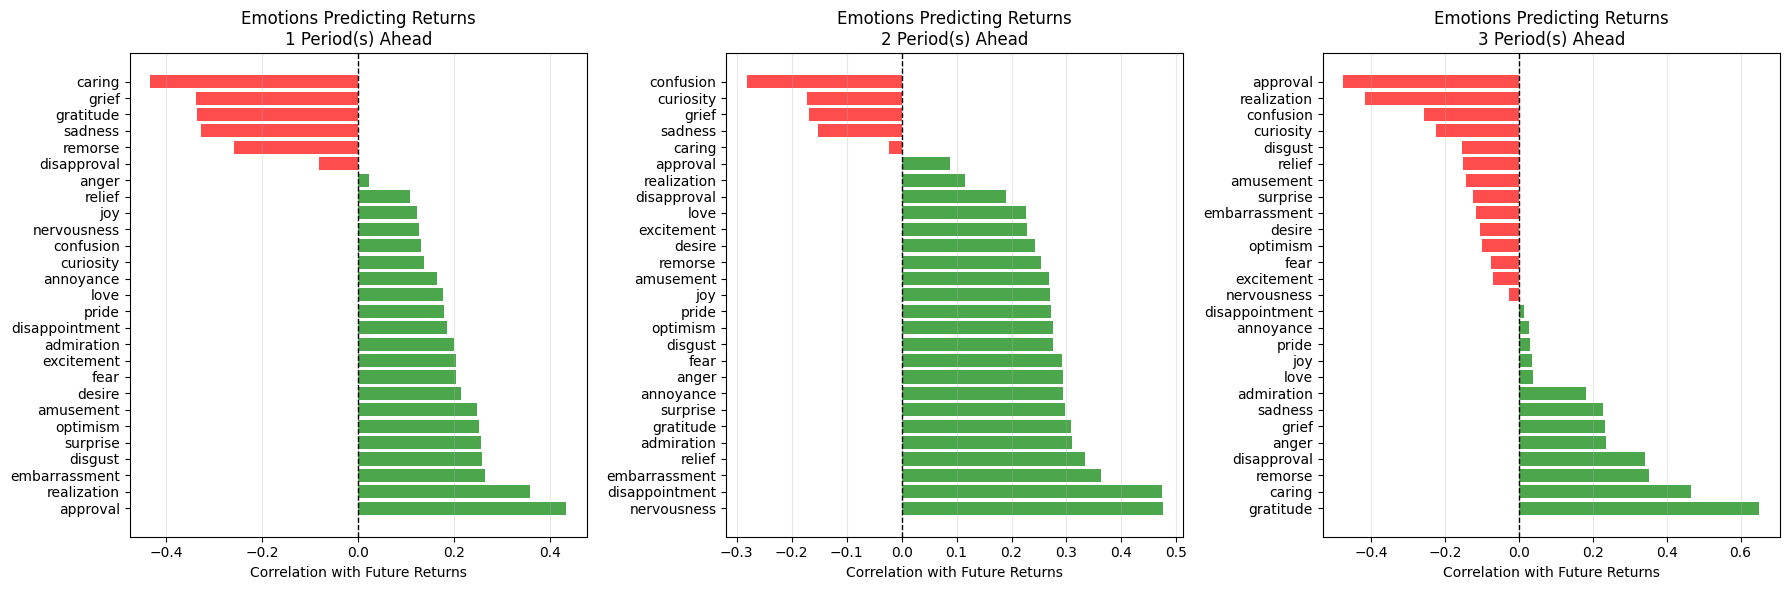

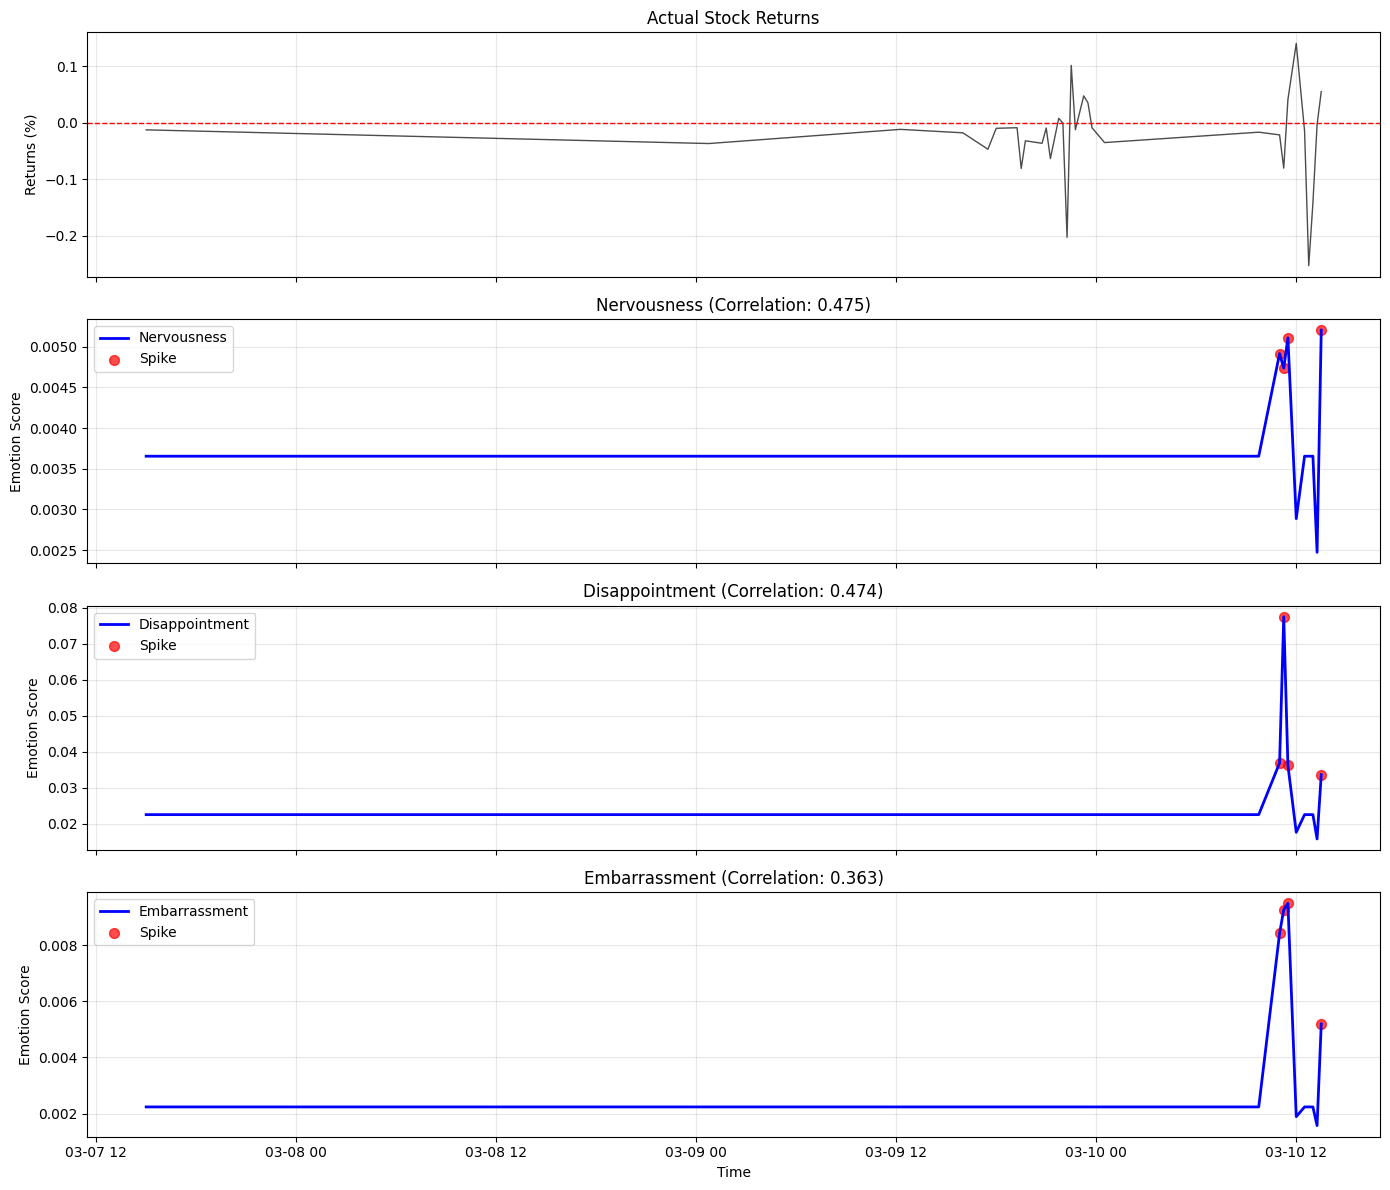

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

# ============================================
# LOAD MERGED DATA
# ============================================

df = pd.read_csv('svb_merged_emotions_stock.csv')
df['timestamp'] = pd.to_datetime(df.index if 'timestamp' not in df.columns else df['timestamp'])
df = df.set_index('timestamp')

print(f"Analyzing {len(df)} time periods")

# ============================================
# DEFINE EMOTIONS (no neutral)
# ============================================

emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 
    'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
    'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise'
]

# ============================================
# LAG ANALYSIS - Multiple Time Lags
# ============================================

print("\n" + "="*60)
print("LAG ANALYSIS - Do emotions PREDICT future returns?")
print("="*60)

# Test different lags (1, 2, 3 periods ahead)
lag_results = {}

for lag in [1, 2, 3]:
    df_lag = df.copy()
    
    # Shift returns forward (predict future)
    df_lag[f'future_returns_{lag}'] = df_lag['returns'].shift(-lag)
    
    # Calculate correlations
    correlations = df_lag[emotion_cols].corrwith(df_lag[f'future_returns_{lag}']).sort_values(ascending=False)
    
    lag_results[f'{lag}_period'] = correlations
    
    print(f"\n{'='*60}")
    print(f"EMOTIONS PREDICTING RETURNS {lag} PERIOD(S) AHEAD")
    print(f"{'='*60}")
    print("\nTop 10 predictive emotions (positive):")
    print(correlations.head(10))
    print("\nTop 10 predictive emotions (negative):")
    print(correlations.tail(10))

# ============================================
# VISUALIZE LAG CORRELATIONS
# ============================================

print("\nCreating lag correlation visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, lag in enumerate([1, 2, 3]):
    ax = axes[idx]
    
    corrs = lag_results[f'{lag}_period'].sort_values(ascending=False)
    
    colors = ['green' if x > 0 else 'red' for x in corrs.values]
    ax.barh(corrs.index, corrs.values, color=colors, alpha=0.7)
    ax.set_xlabel('Correlation with Future Returns')
    ax.set_title(f'Emotions Predicting Returns\n{lag} Period(s) Ahead')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('emotion_lag_predictions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_lag_predictions.png")

# ============================================
# GRANGER CAUSALITY STYLE ANALYSIS
# ============================================

print("\n" + "="*60)
print("DETAILED PREDICTIVE ANALYSIS")
print("="*60)

# For each emotion, check if it predicts better than random
df_pred = df.copy()

# Create lagged features
for emotion in emotion_cols:
    df_pred[f'{emotion}_lag1'] = df_pred[emotion].shift(1)

df_pred['future_returns'] = df_pred['returns'].shift(-1)
df_pred = df_pred.dropna()

# Calculate correlations for lagged emotions
lagged_emotion_cols = [f'{e}_lag1' for e in emotion_cols]
pred_correlations = df_pred[lagged_emotion_cols].corrwith(df_pred['future_returns'])

# Remove '_lag1' suffix for display
pred_correlations.index = pred_correlations.index.str.replace('_lag1', '')
pred_correlations = pred_correlations.sort_values(ascending=False)

print("\nEmotions with PREDICTIVE POWER (lagged 1 period):")
print(pred_correlations)

# ============================================
# DIRECTIONAL ACCURACY
# ============================================

print("\n" + "="*60)
print("DIRECTIONAL ACCURACY - Can emotions predict UP vs DOWN?")
print("="*60)

# Create binary up/down variables
df_pred['future_up'] = (df_pred['future_returns'] > 0).astype(int)

# For top 5 predictive emotions, check directional accuracy
top_emotions = pred_correlations.head(5).index

for emotion in top_emotions:
    # When emotion is high (above median), what % of time does stock go up?
    emotion_high = df_pred[emotion] > df_pred[emotion].median()
    
    accuracy_when_high = df_pred[emotion_high]['future_up'].mean()
    accuracy_when_low = df_pred[~emotion_high]['future_up'].mean()
    
    print(f"\n{emotion.upper()}:")
    print(f"  When {emotion} HIGH → Stock goes UP {accuracy_when_high*100:.1f}% of time")
    print(f"  When {emotion} LOW  → Stock goes UP {accuracy_when_low*100:.1f}% of time")
    print(f"  Predictive edge: {(accuracy_when_high - accuracy_when_low)*100:.1f} percentage points")

# ============================================
# TIME SERIES: EMOTION SPIKES → FUTURE RETURNS
# ============================================

print("\nCreating predictive time series plot...")

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Get top 3 predictive emotions
top_3_emotions = pred_correlations.head(3).index

# Plot 1: Stock returns
axes[0].plot(df.index, df['returns'], color='black', linewidth=1, alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_ylabel('Returns (%)')
axes[0].set_title('Actual Stock Returns')
axes[0].grid(alpha=0.3)

# Plots 2-4: Top 3 predictive emotions
for idx, emotion in enumerate(top_3_emotions):
    ax = axes[idx + 1]
    
    # Plot emotion intensity
    ax.plot(df.index, df[emotion], label=f'{emotion.capitalize()}', 
            color='blue', linewidth=2)
    
    # Highlight spikes (above 75th percentile)
    threshold = df[emotion].quantile(0.75)
    spikes = df[emotion] > threshold
    ax.scatter(df[spikes].index, df[spikes][emotion], 
              color='red', s=50, alpha=0.7, label='Spike')
    
    ax.set_ylabel('Emotion Score')
    ax.set_title(f'{emotion.capitalize()} (Correlation: {pred_correlations[emotion]:.3f})')
    ax.legend()
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.savefig('predictive_emotions_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Saved: predictive_emotions_timeseries.png")

# ============================================
# SAVE RESULTS
# ============================================

# Save lag correlations
lag_df = pd.DataFrame(lag_results)
lag_df.to_csv('emotion_lag_correlations.csv')
print("\n✓ Saved: emotion_lag_correlations.csv")

# Save predictive analysis
pred_correlations.to_csv('emotion_predictive_power.csv')
print("✓ Saved: emotion_predictive_power.csv")

print("\n" + "="*60)
print("LAG ANALYSIS COMPLETE!")
print("="*60)
print("\nKey Question Answered:")
print("Do emotions at time T predict returns at time T+1?")
print("\nCheck the visualizations and CSV files for results!")